# Cardiovascular Disease Classifier

Problem Statement : To build an application to classify the patients to be healthy or suffering from cardiovascular disease based on the given attributes. 

In [1]:
#importing necessary libraries
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#loading data
df=pd.read_csv(r'C:\Users\joshi\Downloads\cardio_train.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [3]:
#shape
df.shape

(69301, 13)

In [4]:
#dropping id 
df.drop('id', axis=1, inplace=True)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [5]:
#data discription
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000
mean,19468.786280,1.349519,164.362217,74.203027,128.829584,96.650092,1.366806,1.226447,0.088051,0.053881,0.803986,0.499589
std,2467.261818,0.476821,8.205337,14.383469,154.775805,189.096240,0.680270,0.572246,0.283371,0.225784,0.396982,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21326.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Observation :
* No missing values
* Assuming age is in number of days
* Outliers in height
* Outliers in ap_hi
* Outliers in ap_lo
* Seems cholestrol and glucose are binary

In [6]:
#dropping duplicates
df.drop_duplicates(inplace=True)
df.shape

(69277, 12)

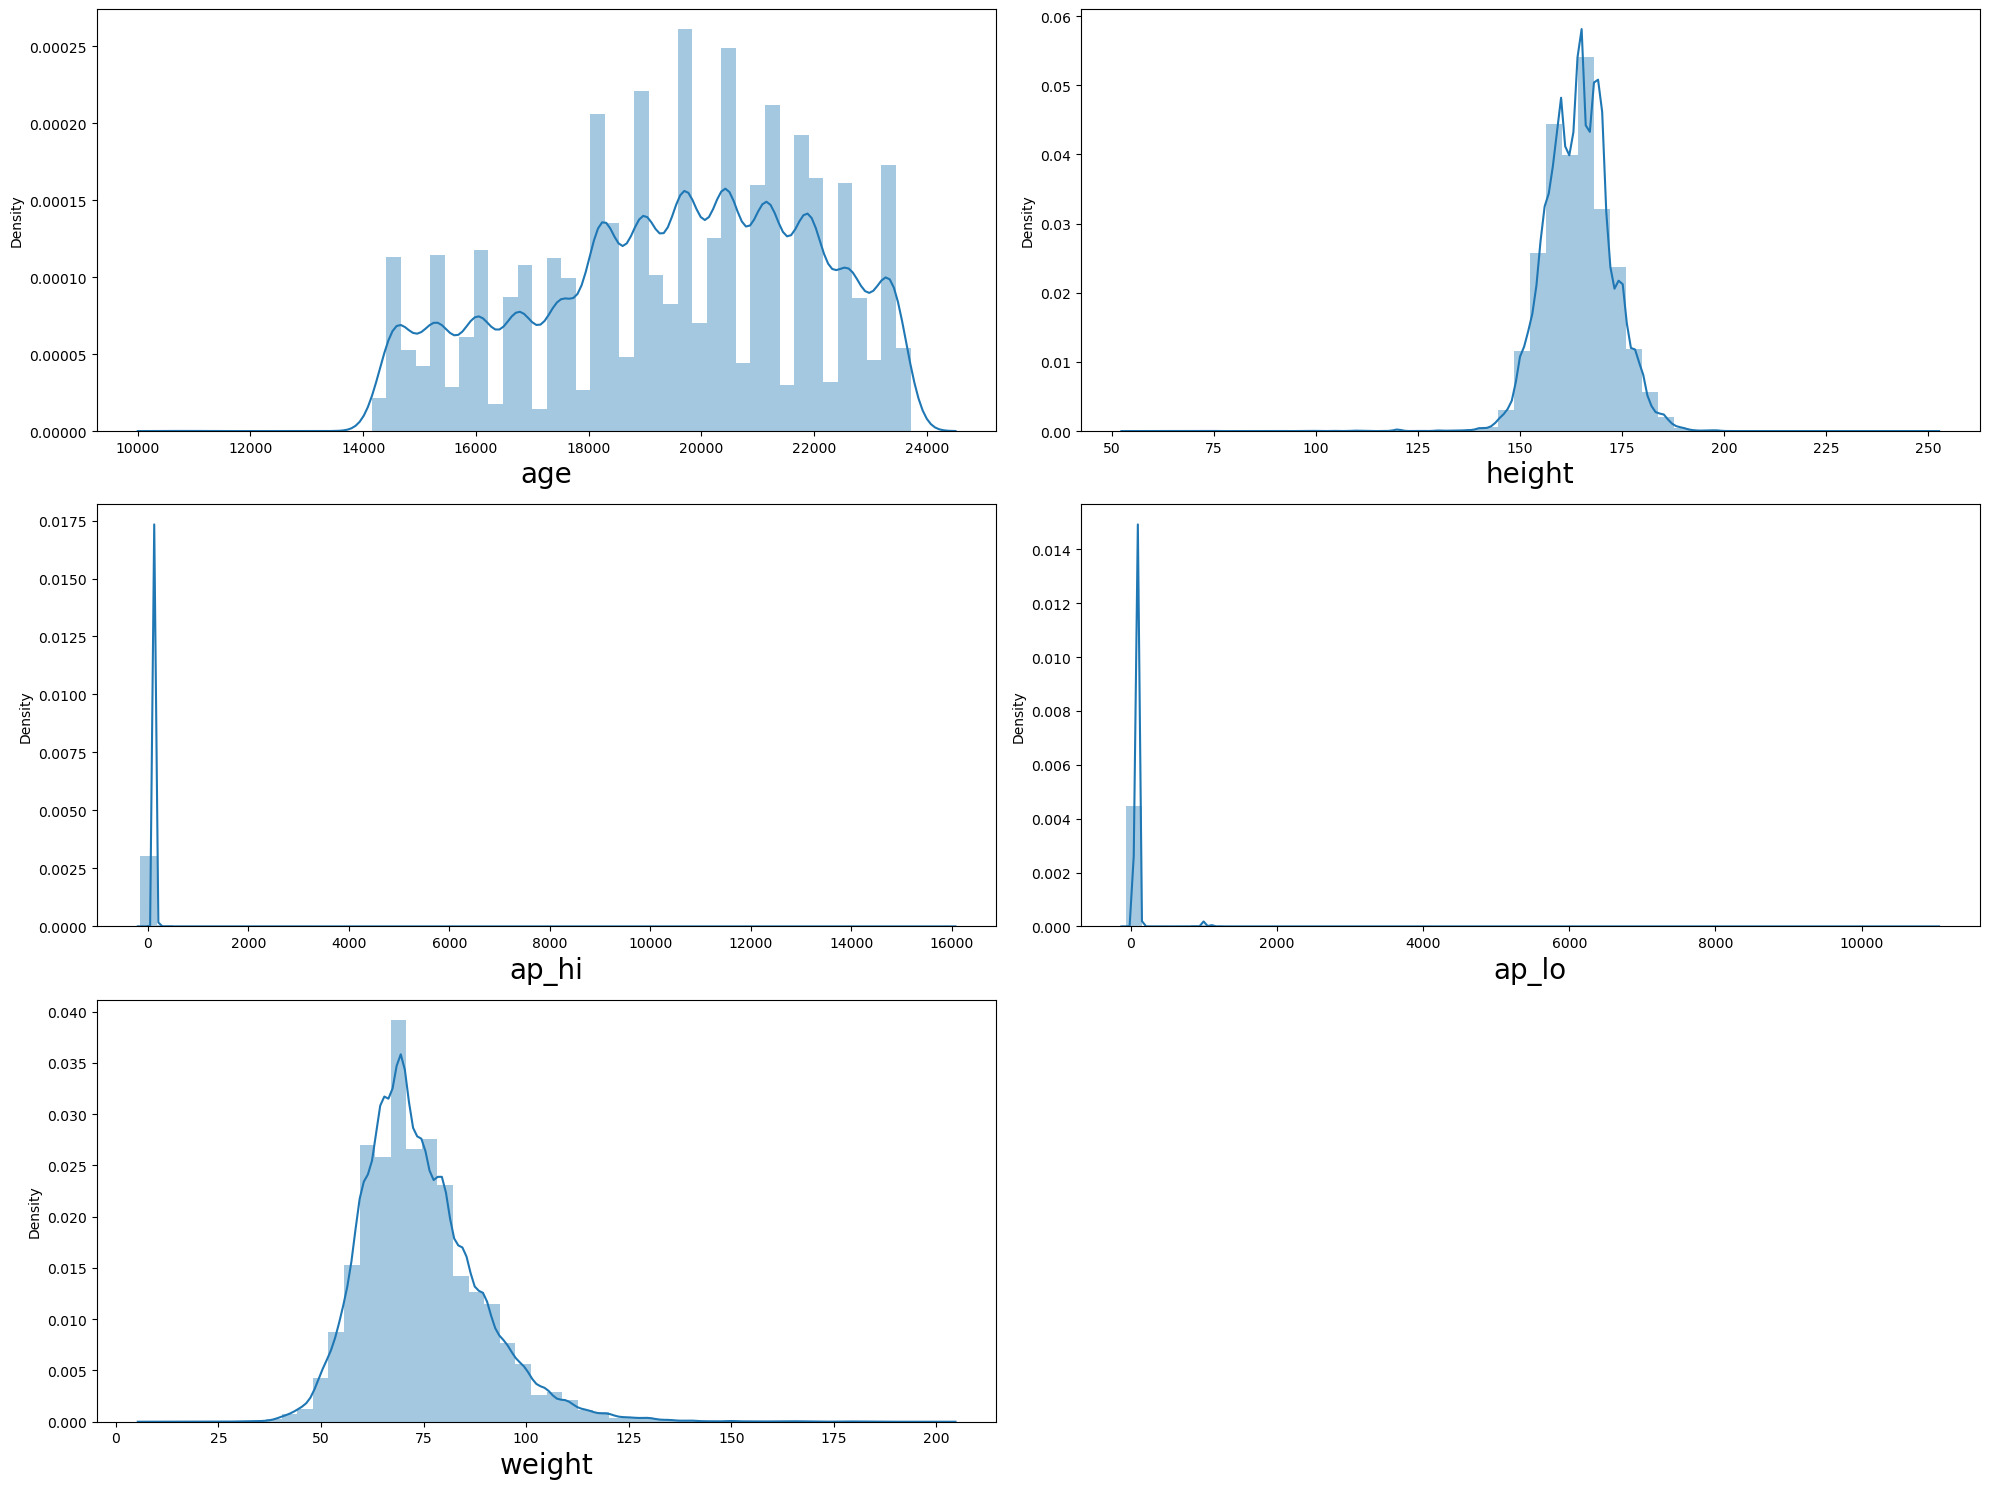

In [7]:
#getting a rough idea about data
plt.figure(figsize=(20,15))
plotnumber=1
for column in df[['age', 'height', 'ap_hi', 'ap_lo', 'weight']]:
    if plotnumber<=6:
        ax=plt.subplot(3, 2, plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column, fontsize=20)
    plotnumber+=1
plt.tight_layout()   

In [8]:
#getting zscore=(x-mean)/std
z_score=zscore(df[['age', 'height', 'ap_hi', 'ap_lo', 'weight']])
abs_z_score=np.abs(z_score)
filtering_entry=(abs_z_score<3).all(axis=1)
df=df[filtering_entry]
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000
mean,19466.779053,1.347268,164.374555,73.566278,126.164430,81.286001,1.362010,1.223575,0.087159,0.053281,0.803949,0.492815
std,2467.040240,0.476105,7.690310,13.195627,17.860035,10.236086,0.677075,0.569505,0.282069,0.224595,0.397011,0.499952
min,14275.000000,1.000000,140.000000,32.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17660.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19702.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21324.000000,2.000000,170.000000,81.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,188.000000,117.000000,401.000000,602.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


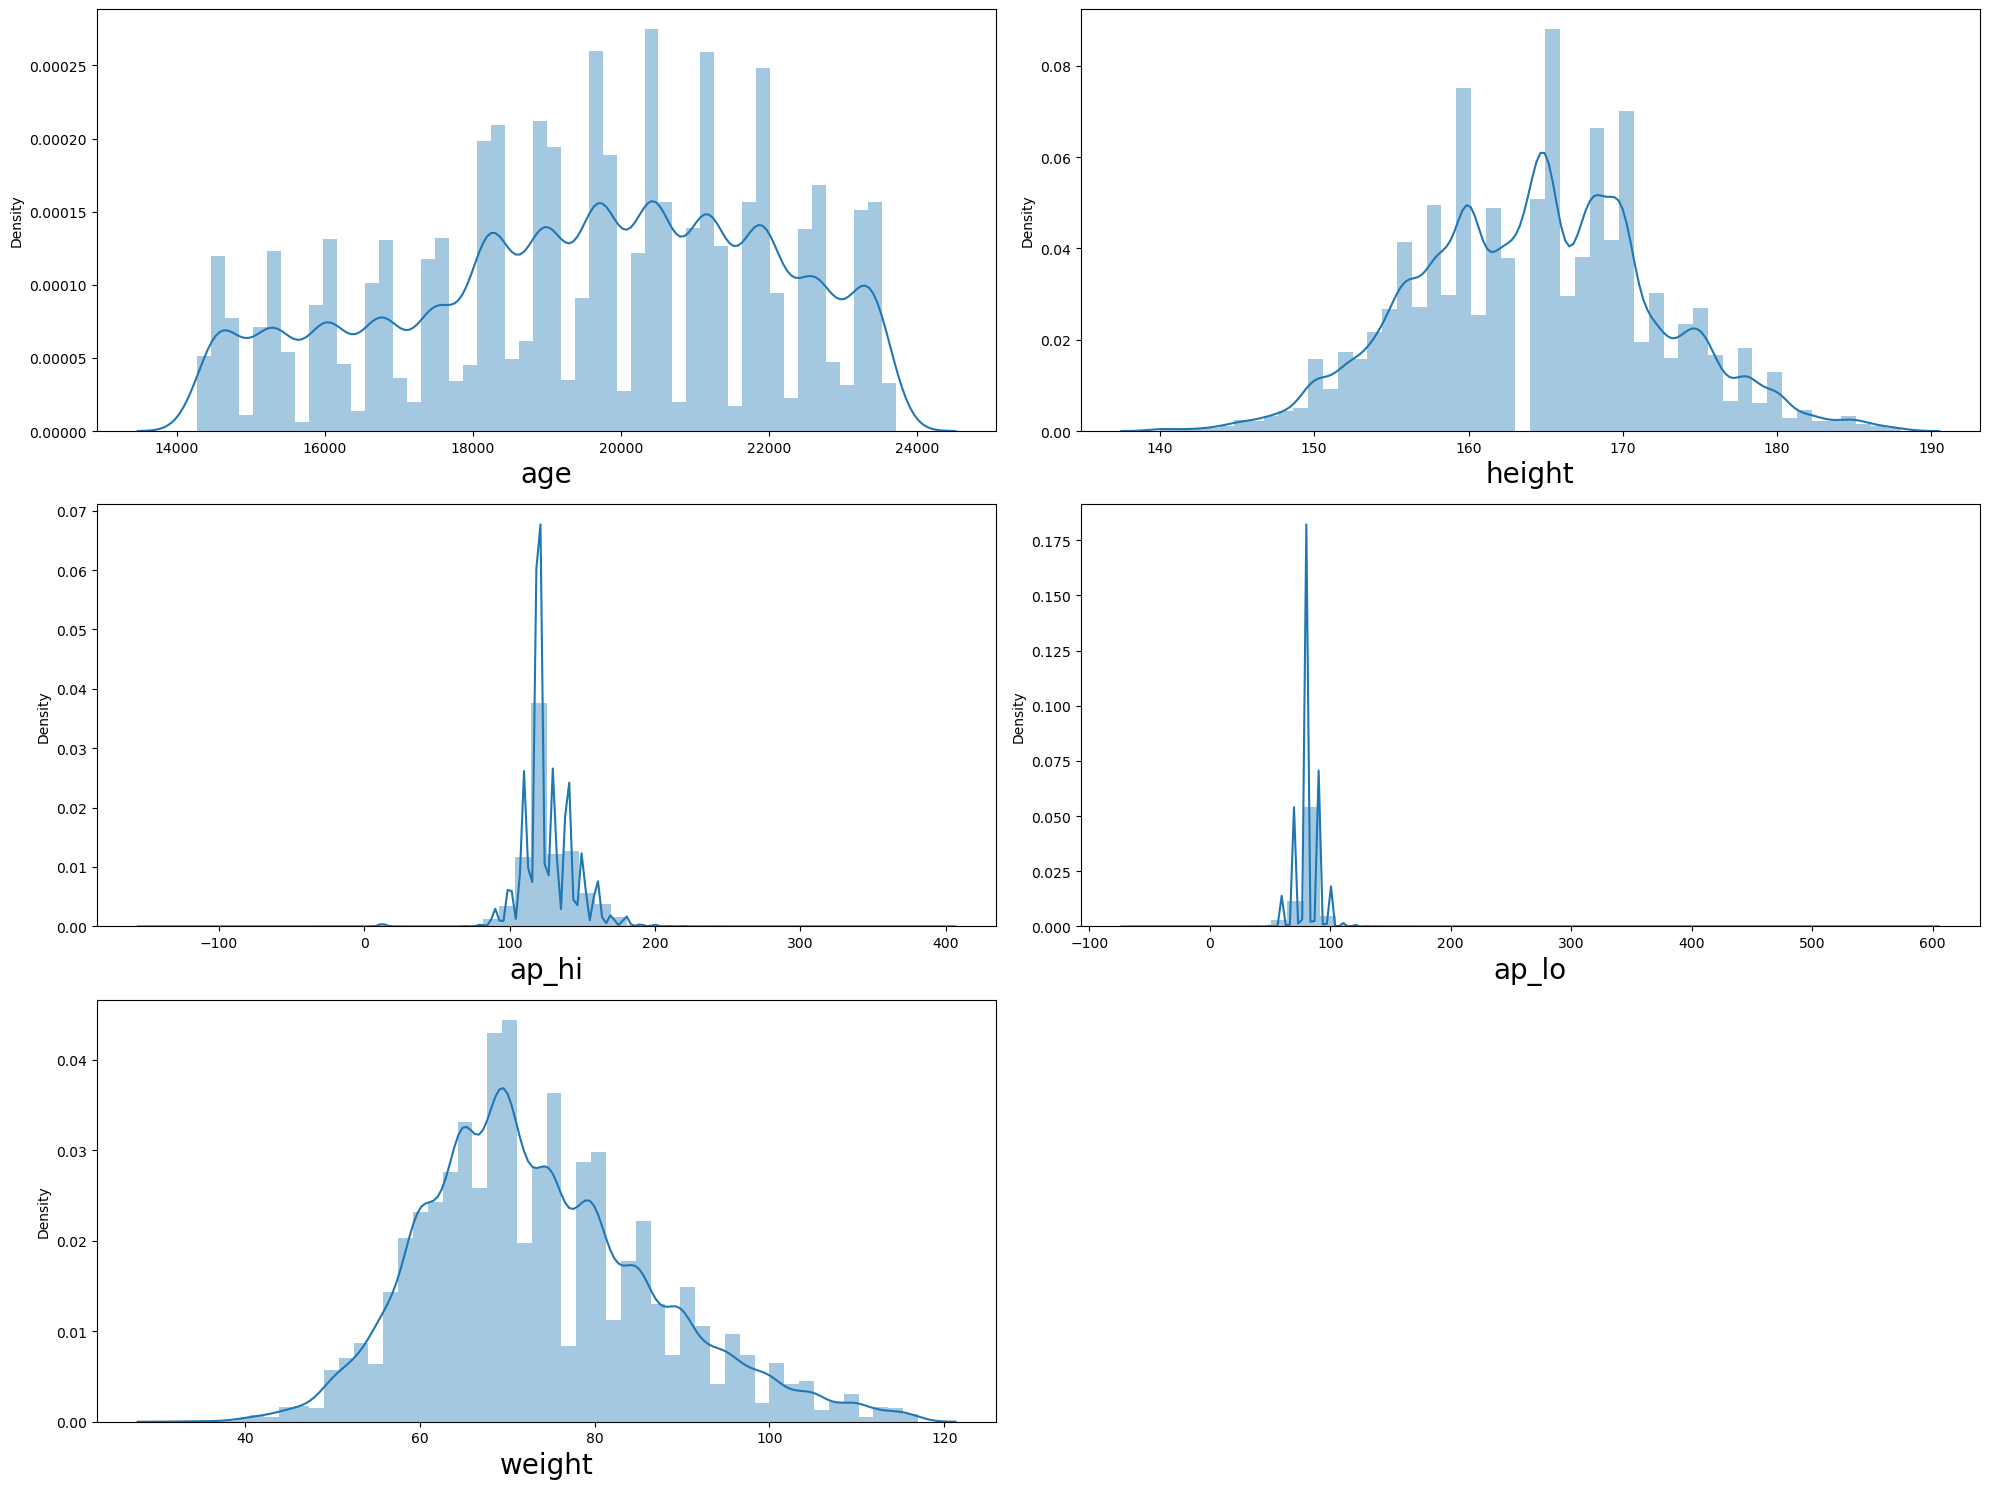

In [9]:
#checking how much skewness we removed
plt.figure(figsize=(20,15))
plotnumber=1
for column in df[['age', 'height', 'ap_hi', 'ap_lo', 'weight']]:
    if plotnumber<=6:
        ax=plt.subplot(3, 2, plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column, fontsize=20)
    plotnumber+=1
plt.tight_layout()   

In [10]:
#cannot make out much from the above plots. let's build the model
x=df.drop(columns=['cardio'], axis=1)
y=df['cardio']

In [11]:
#train test split
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.30, random_state=41)

In [12]:
#defining the function for accuracy
def metric_score(clf, x_train, x_test, y_train, y_test, train=True):
    if train:
        y_pred=clf.predict(x_train)
        print(f"accuracy score (train result):{accuracy_score(y_train, y_pred)*100:.2f}%")
    elif train==False:
        pred=clf.predict(x_test)
        print(f"accuracy score (test result):{accuracy_score(y_test, pred)*100:.2f}%")
        print("\nclassification report : \n \n", classification_report(y_test, pred, digits=2))    

In [13]:
#instantiating random forest classifier and training
random_clf=RandomForestClassifier()
random_clf.fit(x_train, y_train)

RandomForestClassifier()

In [14]:
#calling the function and passing the dataset to check the train and test accuracy
metric_score(random_clf, x_train, x_test, y_train, y_test, train=True) #for training score
metric_score(random_clf, x_train, x_test, y_train, y_test, train=False) #for testing score

accuracy score (train result):99.99%
accuracy score (test result):71.17%

classification report : 
 
               precision    recall  f1-score   support

           0       0.71      0.73      0.72     10243
           1       0.71      0.69      0.70      9965

    accuracy                           0.71     20208
   macro avg       0.71      0.71      0.71     20208
weighted avg       0.71      0.71      0.71     20208



Parameters tuning using GridsearchCV.

In [15]:
#random forest classifier
params={'n_estimators':[13, 15],
        'criterion':['entropy', 'gini'],
        'max_depth':[10, 15],
        'min_samples_split':[10, 11],
        'min_samples_leaf':[5, 6]
       }
grd=GridSearchCV(random_clf, param_grid=params)
grd.fit(x_train, y_train)
print('best params=', grd.best_params_)

best params= {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 13}


In [16]:
#reinstatiating with best params
random_clf=grd.best_estimator_
random_clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=6, min_samples_split=10,
                       n_estimators=13)

In [17]:
#again calling the function and passing the dataset to check the train and test accuracy
metric_score(random_clf, x_train, x_test, y_train, y_test, train=True) #for training score
metric_score(random_clf, x_train, x_test, y_train, y_test, train=False) #for testing score

accuracy score (train result):74.87%
accuracy score (test result):73.50%

classification report : 
 
               precision    recall  f1-score   support

           0       0.72      0.79      0.75     10243
           1       0.76      0.68      0.72      9965

    accuracy                           0.74     20208
   macro avg       0.74      0.73      0.73     20208
weighted avg       0.74      0.74      0.73     20208



Let's plot ROC AUC curve to choose the best model.

In [18]:
#roc auc curve without hyperparams tuning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [19]:
#loading and spliting data into training and testing sets
x=df.drop(columns=['cardio'], axis=1)
y=df['cardio']
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.25, random_state=52)

#training the data
lr=LogisticRegression()
dt=DecisionTreeClassifier()
rf=RandomForestClassifier()
kn=KNeighborsClassifier()

Let's check ROC AUC curve for the fitted model.

threshold of Logistic Regression [           inf 9.96265759e-01 9.96241356e-01 ... 4.33563113e-03
 4.25102095e-03 5.38029969e-05]
threshold of RandomForest [       inf 1.         0.99       0.98       0.97       0.96
 0.95       0.94       0.93       0.92       0.91       0.9
 0.89       0.885      0.88       0.87       0.86       0.855
 0.85       0.84       0.83       0.82       0.81       0.8
 0.79       0.78       0.77166667 0.77       0.76       0.75
 0.74       0.73       0.72       0.71       0.7        0.6915
 0.69       0.68833333 0.68       0.67333333 0.67       0.66166667
 0.66       0.65       0.645      0.64       0.63       0.62
 0.6125     0.61       0.6        0.59       0.58       0.57333333
 0.57       0.56       0.55333333 0.55       0.54083333 0.54
 0.53333333 0.53       0.52       0.51666667 0.51       0.5
 0.49       0.48       0.47666667 0.47       0.46       0.45
 0.44       0.43       0.42       0.415      0.41       0.4
 0.39666667 0.39333333 0.39       0.38  

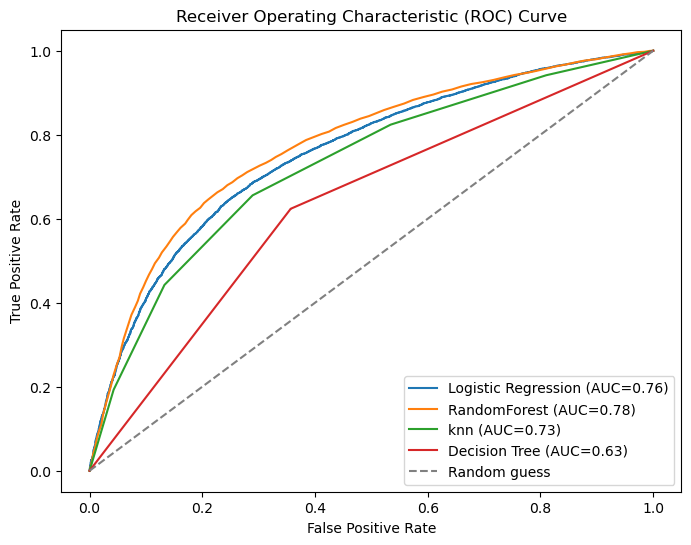

In [20]:
models={'Logistic Regression': lr, 'RandomForest':rf, 'knn':kn, 'Decision Tree':dt}

#calculating roc auc curve for each model
plt.figure(figsize=(8, 6))
for name, model in models.items(): #reading key and values from the items
    model.fit(x_train, y_train) #each model training
    y_prob=model.predict_proba(x_test)[:, 1] #predict probability of each model
    fpr, tpr, _=roc_curve(y_test, y_prob) #finding true and false positive rate ('_' is threshold)
    print('threshold of', name, _)
    roc_auc=auc(fpr, tpr) #auc score for each model captured
    plt.plot(fpr, tpr, label='{} (AUC={:.2f})'.format(name, roc_auc)) #plotting roc curve

#adding labels and legends to the plot
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Clearly, Random Forest Classifier will work best for this model!

and we're done here!